## Overfitting: Learns training data too well, fails on new data.
Also known as:
* Bias-Variance Tradeoff issue
* Overinterpretation
* Too specific to the training data
* Poor generalization
* Model “hallucination” or false positives
* High variance / low robustness
* Over-tuning / overtraining

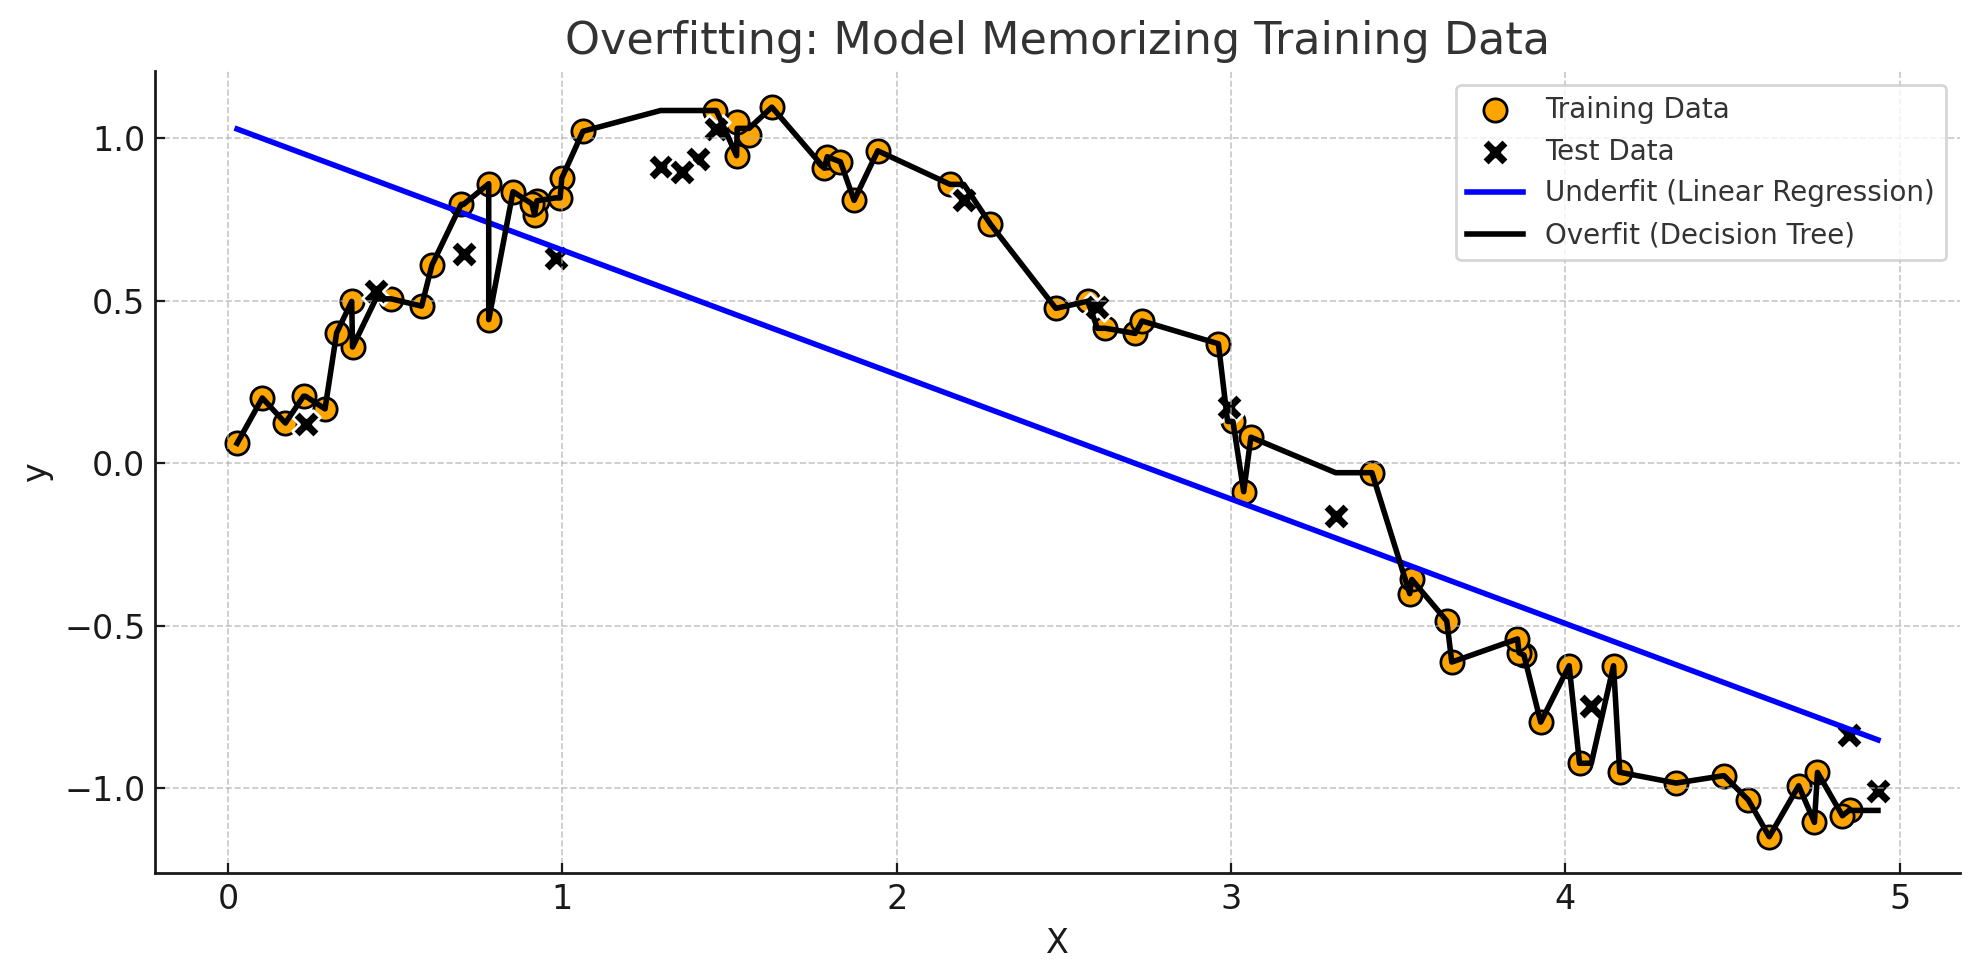

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Read the datasets
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# Optional: Show the shapes to confirm they're loaded
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Gender submission shape:", gender_submission.shape)

Train shape: (891, 12)
Test shape: (418, 11)
Gender submission shape: (418, 2)


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the data
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")

# Define the required features
required_cols = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch', 'PassengerId', 'SibSp']

# Filter to only those columns + 'Survived'
train_df = train_df[required_cols + ['Survived']]

# Encode categorical 'Sex' to numeric
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

# Fill missing values with column medians
train_df = train_df.fillna(train_df.median(numeric_only=True))

# Define features and target
X = train_df[required_cols]           # input features
y = train_df['Survived']              # target variable

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_depth_num = 8
# Overfitted decision tree
tree_model = DecisionTreeClassifier(
    max_depth=max_depth_num,           # No limit → overfit
    min_samples_split=2,      # Allows tiny splits
    min_samples_leaf=1,       # Allows leaves with one row
    random_state=42
)
tree_model.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, tree_model.predict(X_train))
test_acc = accuracy_score(y_test, tree_model.predict(X_test))

print("Overfitted Decision Tree:")
print("Train Accuracy:", round(train_acc, 3))
print("Test Accuracy:", round(test_acc, 3))

gap = train_acc - test_acc
print("Accuracy Gap:", round(gap, 3))

Overfitted Decision Tree:
Train Accuracy: 0.92
Test Accuracy: 0.799
Accuracy Gap: 0.121


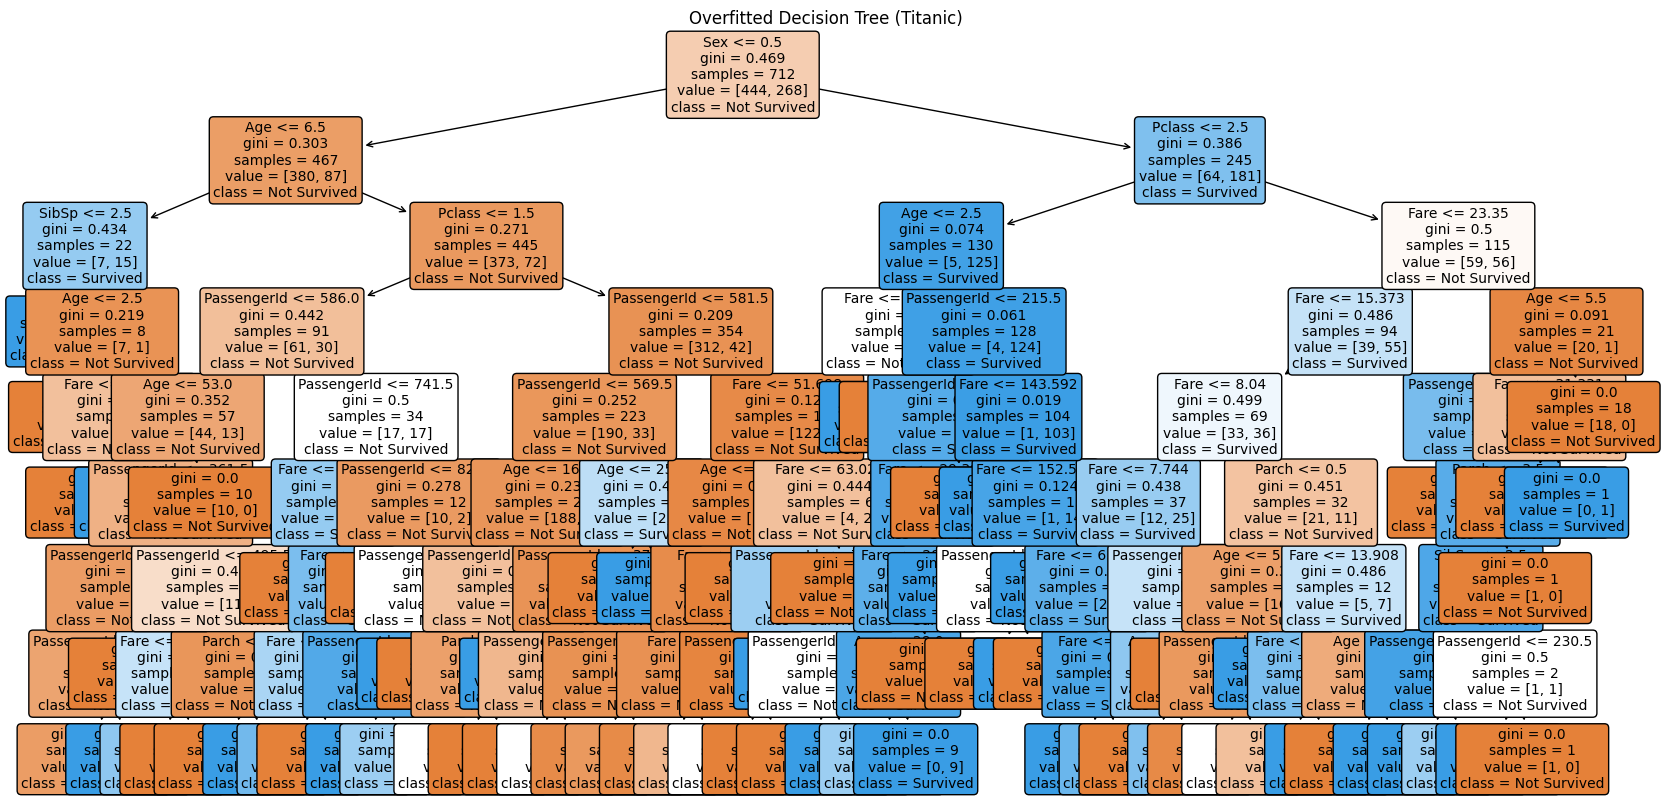

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set figure size
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(tree_model, 
          feature_names=X.columns, 
          class_names=['Not Survived', 'Survived'], 
          filled=True, 
          rounded=True, 
          fontsize=10)

plt.title("Overfitted Decision Tree (Titanic)")
plt.show()


In [29]:
# Step 1: Select only the needed columns
test_df = test_df[required_cols]  # filter out unwanted columns

# Step 2: Encode 'Sex'
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Step 3: Fill missing values with column median
test_df = test_df.fillna(test_df.median(numeric_only=True))

# Step 4: Save PassengerId for submission
passenger_ids = test_df['PassengerId']

# Step 5: Prepare features (must match training columns in same order)
X_features = test_df[required_cols]  # includes PassengerId if it was in training

# Step 6: Predict
test_predictions = tree_model.predict(X_features)

# Step 7: Create submission file
output = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': test_predictions
})
output.to_csv('submission.csv', index=False)
print("Submission file saved successfully")

Submission file saved successfully


## Tunned Paramter Decision Tree

Train Accuracy: 0.834
Test Accuracy: 0.799
Accuracy Gap: 0.035


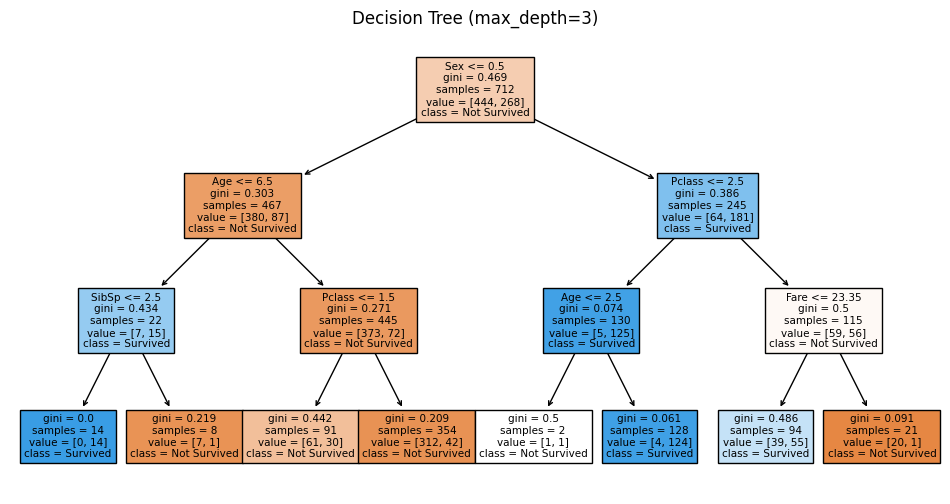

In [30]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, tree_model.predict(X_train))
test_acc = accuracy_score(y_test, tree_model.predict(X_test))

print("Train Accuracy:", round(train_acc, 3))
print("Test Accuracy:", round(test_acc, 3))
print("Accuracy Gap:", round(train_acc - test_acc, 3))

# Visualize
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

## Tune Max Depth Tree

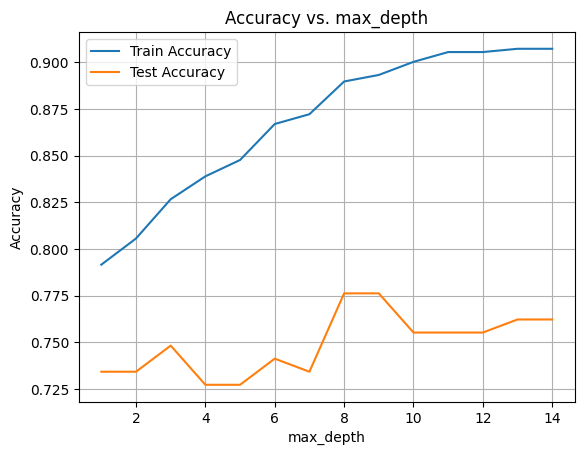

In [31]:
# Load and clean data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df = df[['Survived', 'Pclass', 'Sex', 'Age']].dropna()
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

X = df[['Pclass', 'Sex', 'Age']]
y = df['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try different max_depth values
depths = range(1, 15)
train_scores = []
test_scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

# Plot results
plt.plot(depths, train_scores, label='Train Accuracy')
plt.plot(depths, test_scores, label='Test Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. max_depth")
plt.legend()
plt.grid(True)
plt.show()
